# Кластеризация. Домашнее задание

### Данные

В предложенных файлах информация с публичных слушаний Москвы по правилам землепользования и застройки (ПЗЗ). В них комментарии жителей города были застенагрофированы, проклассифицированы (за/против) и нанесены на карту. Данные предоставлены в 2 вариантах, для задания можно использовать любой:
* geo_comment.xlsx
    * **comment** - комментарий одного или списка жителей к проект
    * **multiplier** - количество авторов комментария (может быть 1, может быть список)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
* geo.xlsx - те же данные, но без текстов комментариев и по 1 голосу на строку (ранее в 1 строке могло быть **multiplier** > 1 голоса)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
    
### Обязательное задание


In [47]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [61]:
alpha = 0.5
random_state = 123456
cmap = 'YlGn'
#cmapf = matplotlib.cm.get_cmap(cmap)

data = pd.read_excel('data/geo/geo.xlsx')
data.head()

,x,y,comment_class
0,37.612416,55.777454,-1
1,37.612416,55.777454,-1
2,37.603298,55.742108,-1
3,37.558526,55.728758,-1
4,37.566431,55.731794,-1


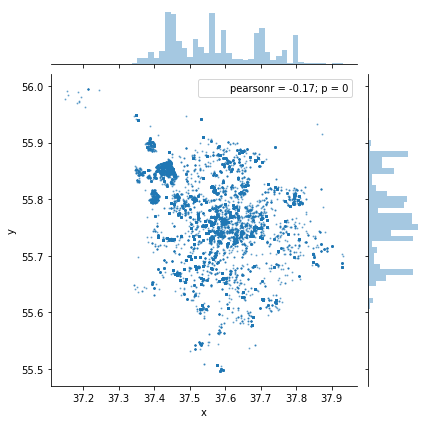

In [29]:
sns.jointplot(data.x, data.y, alpha=alpha, s=1);

In [30]:
from sklearn.cluster import KMeans, DBSCAN

* визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)

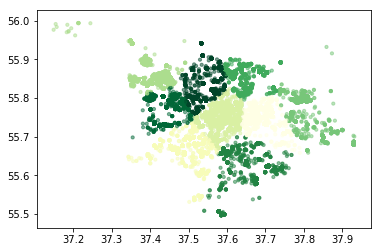

In [62]:
pred = KMeans(n_clusters=9, n_jobs=-1, random_state=random_state).fit_predict(data[['x', 'y']])
plt.scatter(data.x, data.y, c=pred, cmap=cmap, alpha=alpha, s=10);

* аналогично исследовать скопления голосов за и против отдельно

In [65]:
pos=data[data.comment_class>0][['x', 'y']]
neg=data[data.comment_class<0][['x', 'y']]

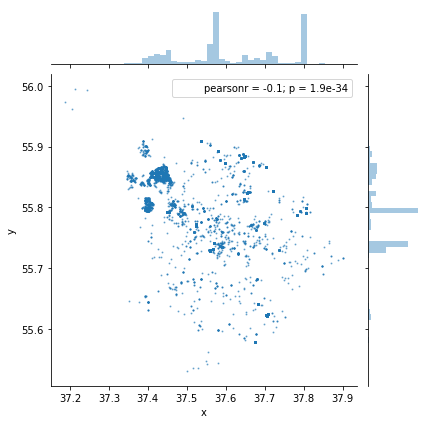

In [69]:
sns.jointplot(pos.x, pos.y, alpha=alpha, s=1);

Взглянем на распределение положительных голосов: можно выделить не менее 4х ярко выраженных кластеров на северо-западе. Остальные голоса распределены более-менее равномерно.

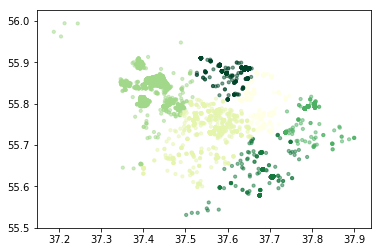

In [73]:
pred = KMeans(n_clusters=6, n_jobs=-1, random_state=random_state).fit_predict(pos[['x', 'y']])
plt.scatter(pos.x, pos.y, c=pred, cmap=cmap, alpha=alpha, s=10);

KMeans сгруппировал явные кластера в один большой и разбил оставшееся еще на несколько частей. Попробуем DBSCAN

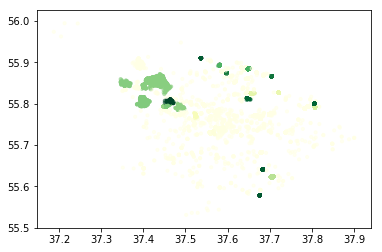

In [99]:
from collections import Counter

thesh=0.005
pred = DBSCAN(eps=1/200, n_jobs=-1).fit_predict(pos[['x', 'y']])
cnt=Counter(pred)
pred = [p if cnt[p]/len(pred)>thesh else -1 for p in pred]
plt.scatter(pos.x, pos.y, c=pred, cmap=cmap, alpha=alpha, s=10);

Подгоняя eps для DBSCAN и порог отсечения, можно добиться четкого выделения скоплений голосов.

Теперь посмотрим как распределялись голоса против.

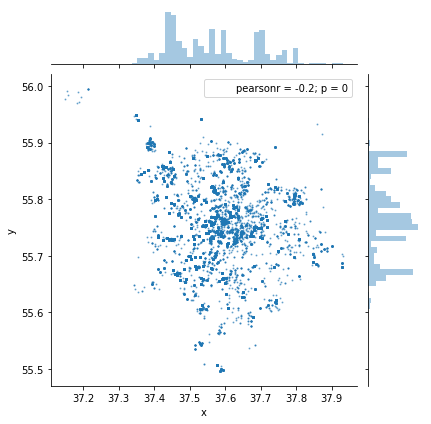

In [100]:
sns.jointplot(neg.x, neg.y, alpha=alpha, s=1);

Здесь голоcа распределены более равномерно, попробуем AgglomerativeClustering

In [105]:
from sklearn.cluster import AgglomerativeClustering

14149

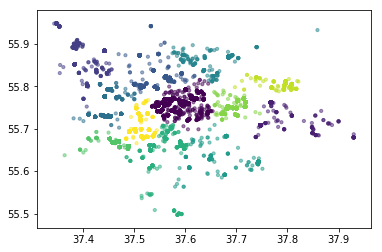

In [166]:
inds = np.array(range(neg.shape[0]))
np.random.shuffle(inds)
neg_cut = neg.loc[inds[:16000]]
neg_cut = neg_cut.dropna()
pred = AgglomerativeClustering(n_clusters=12, linkage='ward').fit_predict(neg_cut)
plt.scatter(neg_cut.x, neg_cut.y, c=pred, cmap='viridis', alpha=alpha, s=10);
neg_cut.shape[0]

*подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)*

In [169]:
def auto_km_clusters(X, ks=range(2, 20)):
    fig, axes = plt.subplots(1, 2, figsize=(15, 2))
    
    inertia = []
    for n_clusters in ks:
        model = KMeans(n_clusters=n_clusters, n_jobs=-1, random_state=random_state)
        model.fit_predict(X)
        inertia.append(model.inertia_)
    axes[0].plot(ks, inertia)
    
    diff = np.diff(inertia)
    diff_r = diff[1:] / diff[:-1]
    axes[1].plot(ks[1:-1], diff_r)

    return ks[np.argmin(diff_r)+1]

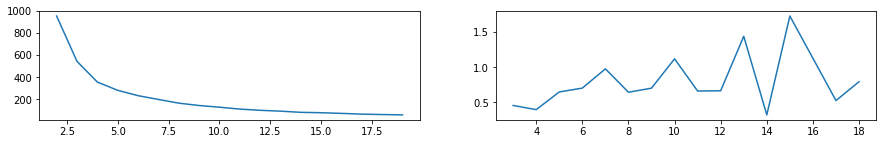

In [171]:
X = data[['x', 'y']]
km_opt = auto_km_clusters(X)

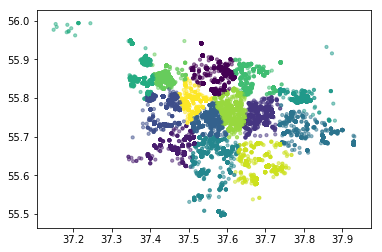

In [173]:
pred = KMeans(n_clusters=km_opt, random_state=random_state, n_jobs=-1).fit_predict(X)
plt.scatter(X.x, X.y, c=pred, cmap='viridis', alpha=alpha, s=10);

### Дополнительные задания
* найти наиболее активные в голосовании районы *(подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')*

* для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию